## <span style="color:blue"> Business Problem: Classify SMS messages as “ok” or “blocked</span>
**Author: João Luiz Pacher**<br>
**2021, Feb 11st**

In [1]:
# Importing the global required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Reading and looking at the data 
First of all let´s look at the data and explore the available information.   

We have 2 datasets:  
    "train_data" to train the model   
    "validation_data" to apply the model and get the classification results

As we will confirm in the nexts cells:   
    "train_data" has 1 attribute SMS and 1 target with 6000 instances.   
    All data are non-nulls and dtype is object.  

### ... about train_data

In [2]:
# Reading the dataset and assigning it to an object
train_data = pd.read_csv('train_data.csv')

In [3]:
# Looking at firsts rows from dataframe train_data
train_data.head(10)

,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked
5,"Apple informa, seu iPhone foi localizado e ent...",blocked
6,Apple Inc. Mobile Apple foi localizado ?s 23:5...,blocked
7,06080446A50403|rápido e seguro.\r\r\nAcesse: h...,blocked
8,"Seu Dispositivo IMEI 3533****4383, Cor BLACK, ...",blocked
9,060804C5130303|bloqueio agora.\r\r\nAcesse: ht...,blocked


In [4]:
# Looking basic info from train dataframe
train_data.shape

(6000, 2)

Train Dataframe has 6000 instances with information about SMS and LABEL.   

In [5]:
# Looking for non-nulls and dtype in train_data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMS     6000 non-null   object
 1   LABEL   6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


Train_data has 6000 non-null instances and dtype is object

## Exploring the target LABEL
Let's explore if the target is balanced and some relations with the SMS content.  

Addittional info: Maximum granted SMS lenght = 160.


In [6]:
# Verifying if the target LABEL is balanced
print('LABEL:', train_data['LABEL'].unique())
train_data['LABEL'].value_counts()

LABEL: ['blocked' 'ok']


ok         4500
blocked    1500
Name: LABEL, dtype: int64

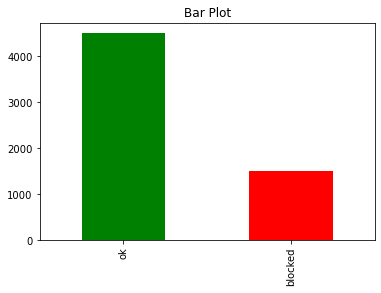

In [7]:
count_Class=pd.value_counts(train_data["LABEL"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show();

In [8]:
# Looking at the more frequent SMS for each kind of LABEL
train_data.groupby('LABEL').describe()

SMS                                                               
        count unique                                                top freq
LABEL                                                                       
blocked  1500   1495  Mercado BTC - Ha uma nova mensagem pendente. h...    3
ok       4500   4364                      131.221.110.19 DNS-SECUNDARIO   13

There is not a big repetition of same SMS for each kind of LABEL.

In [9]:
# Let's create a new feature LENGHT and check the number of characters in SMS
# Knowing that the maximum number of characters in SMS = 160
train_data['LENGHT'] = train_data['SMS'].apply(len)
train_data.head()

,SMS,LABEL,LENGHT
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked,142
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked,52
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked,47
3,Atualizacao ainda nao foi executado em sua con...,blocked,109
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked,47


Text(0, 0.5, 'Frequência')

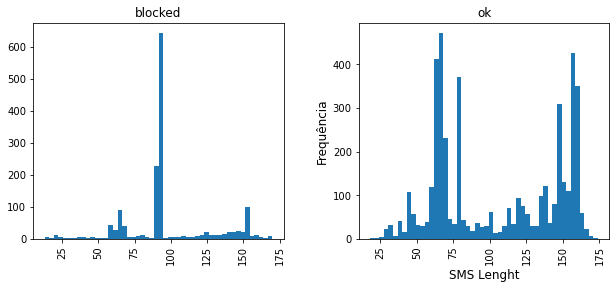

In [10]:
# Looking how LENGHT varies according to LABEL
train_data.hist(column='LENGHT', by='LABEL', bins=50,figsize=(10,4))
plt.xlabel("SMS Lenght",fontsize = 12) 
plt.ylabel("Frequência", fontsize = 12)

It's inconclusive. There is no trend of LABEL in terms of LENGHT.

In [11]:
#Let's delete column LENGHT because it is unuseful
del train_data['LENGHT']

## Implementation of Bag of Words Approach (BoW)


Bag of words approach is a way of extracting features from the text for use in machine learning algorithms.  

In this approach, we use the tokenized words for each observation and find out the frequency of each token.   

Using this process we will convert a collection of documents to a matrix, with each document being a row and each word(token) being the column, and the corresponding (row,column) values being the frequency of occurrence of each word or token in that document.

## Creating corpus

First step is to create a corpus, which is a collection of machine-readable texts, a large and structured set of texts.   

We import ‘re’ package and remove punctuation, special characters and convert all characters to lower case.   

After that, we need to split a message into words to remove stop-words and to perform stemming.   

We import Portuguese stop-words from the NLTK package and removed them if found in the sentence.   

While removing stop-words, we perform stemming that is if the word is not a stop-word, it will be converted to its root form. This is called stemming.   

Then we are joining the words in the list again to form a message without any stop-words and all words will be present in its root form. Then we append messages to the corpus.

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [13]:
# Creating a corpus of refinned messages
stemming = PorterStemmer()
corpus = []

for i in range (0,len(train_data)):
    s1 = re.sub('[^a-zA-Z]',repl = ' ',string = train_data['SMS'][i])
    s1.lower()
    s1 = s1.split()
    s1 = [stemming.stem(word) for word in s1 if word not in set(stopwords.words('portuguese'))]
    s1 = ' '.join(s1)
    corpus.append(s1)

corpus[50]

'support appl Se requier verifiqu su ID appl visit el siguient enlac detal http icloudfind support hntw sG'

## Tokenizing and vectorizing the text

We’ll import Count-Vectorizer from Scikit-learn library to tokenize and vectorize the text.   

By using this Count-Vectorizer we’ll tokenize a collection of text documents and built a vocabulary, this vocabulary is also used to encode new documents.   

To use this Count-Vectorizer, first, we’ll create an instance of Count-Vectorizer class.   

Then fit () function is used to learn vocabulary from the document and the transform() function is used to encode as a vector.   

This vector represents the length of the entire vocabulary and the count for the number of times each word appeared in the document.   

Now we have a numeric vector that has been converted from a string of text.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer =CountVectorizer()


In [15]:
X = countvectorizer.fit_transform(corpus).toarray()

In [16]:
X.shape

(6000, 5221)

In [17]:
# Assigning all the words in an object
# This feature_cols with be used further in the validation_data vectorizing process
feature_cols = countvectorizer.get_feature_names()
feature_cols

['aa',
 'aaa',
 'aacd',
 'aaef',
 'aaj',
 'aapp',
 'aar',
 'ab',
 'abaixo',
 'abatia',
 'abb',
 'abba',
 'abc',
 'abcd',
 'abdia',
 'abdovaldo',
 'abdx',
 'abel',
 'abelardo',
 'abelmar',
 'aberto',
 'abertura',
 'abigaelli',
 'abilio',
 'abimael',
 'abinadabia',
 'abnb',
 'abner',
 'about',
 'abraao',
 'abreu',
 'abrir',
 'absalao',
 'ac',
 'academi',
 'acassio',
 'acc',
 'accacio',
 'accamargo',
 'accentur',
 'access',
 'accesslcloud',
 'account',
 'acdigit',
 'acdigita',
 'ace',
 'acelino',
 'acesa',
 'acesqjz',
 'acess',
 'acessando',
 'acessar',
 'acesso',
 'acessoseguro',
 'acion',
 'ack',
 'acknowledg',
 'ackv',
 'acl',
 'acmadvocacia',
 'acompanh',
 'acompanhado',
 'acompanhei',
 'acordo',
 'across',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'ada',
 'adaia',
 'adailson',
 'adailton',
 'adalberon',
 'adalberto',
 'adalgisa',
 'adalicio',
 'adalton',
 'adam',
 'adani',
 'adao',
 'adaofaraco',
 'adar',
 'adason',
 'adauto',
 'adbor',
 'addan',
 'addit',
 'addmark',
 'address

In [18]:
y = train_data['LABEL'].values
print(y)

['blocked' 'blocked' 'blocked' ... 'ok' 'ok' 'ok']


In [19]:
# Let's now balance the target with oversampling using the algorithm SMOTE (Synthetic Minority Oversample)
from imblearn.over_sampling import SMOTE

In [20]:
# Transforming the dataset
oversample = SMOTE(random_state = 12)
X, y = oversample.fit_resample(X, y)

In [21]:
# Summarizing the new class distribution
from collections import Counter
counter = Counter(y)
print(counter)

Counter({'blocked': 4500, 'ok': 4500})


We confirm above that the target LABEL is now balanced.

## Train – Test Split

Let's split the train_data into Train and Test subsets with Scikit-learn.

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, stratify=y,random_state=100)
print(X_train.shape)
print(X_test.shape)

(6300, 5221)
(2700, 5221)


## Naïve Bayes Model

A good text classifier is a classifier that efficiently categorizes large sets of text documents in a reasonable time frame and with acceptable accuracy, and that provides classification rules that are humanly readable for possible fine-tuning.   

Despite the limitation in assuming independence of the attributes Naive Bayes classifier yields good results.

One of the major advantages that Naive Bayes has over other classification algorithms is its ability to handle an extremely large number of features. In our case, each word is treated as a feature and there are thousands of different words. Also, it performs well even with the presence of irrelevant features and is relatively unaffected by them.

The other major advantage it has is its relative simplicity. Naive Bayes' works well right out of the box and tuning it's parameters is rarely ever necessary, except usually in cases where the distribution of the data is known.

It rarely ever overfits the data.

Another important advantage is that its model training and prediction times are very fast for the amount of data it can handle.

In [23]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB()

In [24]:
# Predicting on test data
y_pred = model.predict(X_test)

## Results

Let's evalute the quality of our model using the classification report grid and plotting it with a heatmap.  

The more important metrics is the Recall for OK SMS, once we want to avoid spam messages to be delivered.  

We can find below Recall (for OK) of our model is 98%. 

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     blocked       0.98      1.00      0.99      1350
          ok       1.00      0.98      0.99      1350

    accuracy                           0.99      2700
   macro avg       0.99      0.99      0.99      2700
weighted avg       0.99      0.99      0.99      2700



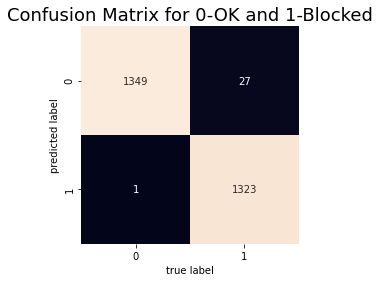

In [26]:
# Plotting the confusion matrix with heatmap
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)

plt.rc('font', size=28)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=28)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18) 
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion Matrix for 0-OK and 1-Blocked');

## Validation

In [27]:
# Reading the dataset and assigning it to an object
validation_data = pd.read_csv('validation_data_original.csv')

In [28]:
# Looking at firsts rows from dataframe validation_data
validation_data.head()

,SMS
0,BB informa:Prezado cliente suas senhas de ACES...
1,BB informa:Prezado cliente suas senhas de ACES...
2,BB informa:Prezado cliente suas senhas de ACES...
3,Node Warning: SFRO01H000001.call.br Warning em...
4,BB informa:Prezado cliente suas senhas de ACES...


In [29]:
# Keeping the original validation data in an object
original_validation_data = validation_data

In [30]:
# Looking basic info from validation dataframe
validation_data.shape

(2000, 1)

validation_data has 2000 instances and 1 attribute SMS

In [31]:
# Looking for non-nulls and dtype in validation_data
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMS     2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


All validation_data are non-null and dtype is object.

In [32]:
# Creating a corpus of refinned messages
stemming = PorterStemmer()
corpus = []

for i in range (0,len(validation_data)):
    s1 = re.sub('[^a-zA-Z]',repl = ' ',string = validation_data['SMS'][i])
    s1.lower()
    s1 = s1.split()
    s1 = [stemming.stem(word) for word in s1 if word not in set(stopwords.words('portuguese'))]
    s1 = ' '.join(s1)
    corpus.append(s1)

corpus[50]

'BB informa prezado client senha acess serao bloqueada seguranca caso nao atual dado http bbseguro app celular mobi dkwz'

In [33]:
# Tokenizing and vectorizing
countvectorizer = CountVectorizer(vocabulary = feature_cols)
X_validation = countvectorizer.fit_transform(corpus).toarray()

In [34]:
X_validation.shape

(2000, 5221)

In [35]:
X_test.shape

(2700, 5221)

In [36]:
# Predicting on validation data
y_pred = model.predict(X_validation)
y_pred

array(['blocked', 'blocked', 'blocked', ..., 'ok', 'ok', 'ok'],
      dtype='<U7')

In [37]:
# Counting the occurrences in the predicted LABEL
import collections, numpy
collections.Counter(y_pred)


Counter({'blocked': 218, 'ok': 1782})

In [38]:
# Printing the SMS for validation and the Predicted Label side by side
original_validation_data['PREDICTED LABEL'] = y_pred
original_validation_data

,SMS,PREDICTED LABEL
0,BB informa:Prezado cliente suas senhas de ACES...,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked
...,...,...
1995,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1996,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1997,bitnuvem.com: Identificamos acesso do IP 179.2...,ok
1998,"enterinapplication: 179.240.169.116, BR, For...",ok


In [39]:
# Exporting Dataframe with results to excel csv file
original_validation_data.to_csv('validation_data.csv', index=False)
